## UMAP clustering on re-trained with PIC (without PCA)   
    - 102 epochs initial (kmeans)
    - 100 additional epochs (PIC)
    - train data:
    
```
Haus8 sgRNA #1	190219_195942-V	B12	
Haus8 sgRNA #2	190219_195942-V	E1	
Haus8 sgRNA #3	190219_195942-V	F2	
Haus8 sgRNA #4	190219_195942-V	G2	
DyncH1 sgRNA #3	190219_195942-V	A1	
Incenp sgRNA #1	190219_195942-V	G4	
Incenp sgRNA #2	190219_195942-V	G6	
Incenp sgRNA #3	190219_195942-V	H1	
Rad21 sgRNA #1	190219_195942-V	H3	
Rad21 sgRNA #2	190219_195942-V	H5	
Rad21 sgRNA #3	190219_195942-V	H7
```
    - test: 

```
Incenp sgRNA #1	190219_195942-V	G5	
Incenp sgRNA #2	190219_195942-V	G8	
No sgRNA Pt11_r01_c12
```
    - clustering with UMAP

Additional cluster comparisons

In [ ]:
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import anndata as ad
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from util import load_model
from util import AverageMeter, Logger, UnifLabelSampler
import shutil
import seaborn as sn
import scanpy.api as sc
import pandas as pd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model=load_model('/home/aogorodnikov/model_alex_pos_continue/checkpoint.pth.tar')

In [ ]:
model.cuda()
model.eval()


In [ ]:
model.top_layer = None
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

In [ ]:
def compute_features(dataloader, model, N):
    
    batch_time = AverageMeter()
    end = time.time()
    model.eval()
    # discard the label information in the dataloader
    for i, (input_tensor, _) in enumerate(dataloader):
        with torch.no_grad():
            input_var = torch.autograd.Variable(input_tensor.cuda())
            aux = model(input_var).data.cpu().numpy()
            if i == 0:
                features = np.zeros((N, aux.shape[1])).astype('float32')

            if i < len(dataloader) - 1:
                features[i * 256: (i + 1) * 256] = aux.astype('float32')
            else:
                # special treatment for final batch
                features[i * 256:] = aux.astype('float32')

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        

    return features

In [ ]:
data_dir = '/home/aogorodnikov/eval'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         pin_memory=True)



In [ ]:
%%time
features = compute_features(dataloader, model, len(dataset))

In [ ]:
features.shape

In [ ]:
# get the file names
dataset.samples[0][0]
samples = [x[0] for x in dataset.samples]


In [ ]:
# construct AnnData obj
adata = ad.AnnData(X=features, obs = samples)
adata.obs["well"] = adata.obs.iloc[:,0].str.extract(r'(Pt\d+_r\d+c\d+)')
adata.obs["image_ID"] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]



In [ ]:
# downsample data
adata = adata[np.random.choice(range(0,adata.shape[0]), size=round(adata.shape[0]*0.2), replace=False),:]

In [ ]:
adata

### UMAP embedding without PCA

In [ ]:
import umap
from sklearn.datasets import fetch_mldata
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# euclidean

reducer = umap.UMAP(random_state=42)
embedding_euc = reducer.fit_transform(adata.X)

In [ ]:
%%time
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')

In [ ]:
adata

In [96]:
%%time
sc.tl.louvain(adata, resolution=7)

CPU times: user 4.68 s, sys: 0 ns, total: 4.68 s
Wall time: 4.48 s


In [78]:
%%time
sc.tl.leiden(adata, resolution=6)

CPU times: user 36.4 s, sys: 0 ns, total: 36.4 s
Wall time: 36 s


In [ ]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['louvain'] = ["_".join(['lol', x]) for x in adata.obs["louvain"]]



#df_emb['leiden'] = adata.obs["leiden"].tolist()




df_emb.sort_values('image_ID').head()




In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.well, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.louvain, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [97]:
## louvain
louvain_ls = []
for well in adata.obs.well.unique():
    sum_well = len(adata.obs.louvain[adata.obs.well == well])
    for i in adata.obs.louvain.unique():
        res = [well, i, len(adata.obs.louvain[(adata.obs.louvain == i) & (adata.obs.well == well)]) / sum_well * 1e4]
        louvain_ls.append(res)

In [98]:
louvain_df = pd.DataFrame(louvain_ls, columns=['well', 'class', 'n_samp'])

In [99]:
louvain_df.head()

,well,class,n_samp
0,Pt11_r02c12,36,125.537767
1,Pt11_r02c12,23,83.926934
2,Pt11_r02c12,6,78.284787
3,Pt11_r02c12,68,64.884689
4,Pt11_r02c12,35,128.358841


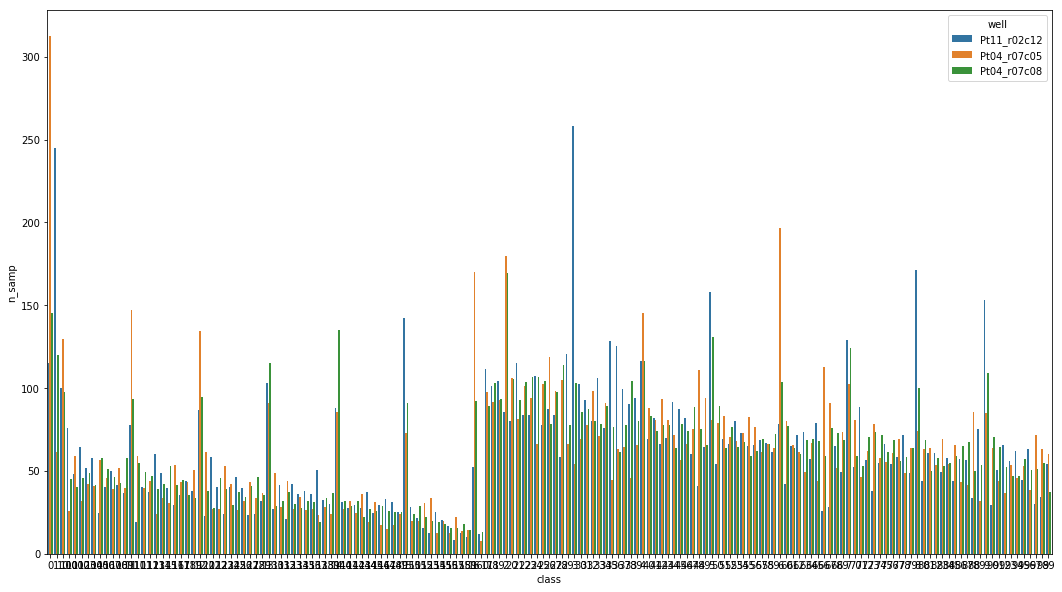

In [100]:
fig, ax = plt.subplots(figsize=(18, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=louvain_df)

In [72]:
## leiden
leiden_ls = []
for well in adata.obs.well.unique():
    sum_well = len(adata.obs.leiden[adata.obs.well == well])
    for i in adata.obs.leiden.unique():
        res = [well, i, len(adata.obs.leiden[(adata.obs.leiden == i) & (adata.obs.well == well)]) / sum_well * 1e4]
        leiden_ls.append(res)

In [73]:
leiden_df = pd.DataFrame(leiden_ls, columns=['well', 'class', 'n_samp'])

In [74]:
leiden_df.head()

,well,class,n_samp
0,Pt11_r02c12,13,574.793709
1,Pt11_r02c12,2,1185.556104
2,Pt11_r02c12,15,101.558643
3,Pt11_r02c12,7,690.457719
4,Pt11_r02c12,1,932.364765


In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=leiden_df)

### Clusters to export  


In [ ]:
import re
import cv2

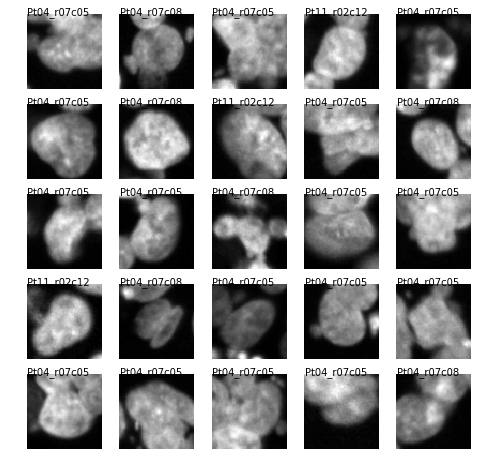

In [103]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = adata.obs.loc[adata.obs.louvain  == '0', 0].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread(rand_select, -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')